In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install SimpleITK
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from google.colab.patches import cv2_imshow
import os
from PIL import Image
from math import *
from random import *
from sklearn.decomposition import PCA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 14.2 MB/s eta 0:00:00


In [ ]:
import os
import SimpleITK as sitk
from skimage.color import rgb2hsv, hsv2rgb

adc_folder = '/content/drive/MyDrive/Dataset_valid/crop_resize_test_ADC'
z_adc_folder = '/content/drive/MyDrive/Dataset_valid/crop_resize_test_ZADC'
output_folder = '/content/drive/MyDrive/Fusion_test'

def process_image_pair(adc_image_path, z_adc_image_path, output_path):
    adc_image = sitk.ReadImage(adc_image_path)
    z_adc_image = sitk.ReadImage(z_adc_image_path)

    adc_data = sitk.GetArrayFromImage(adc_image)
    z_adc_data = sitk.GetArrayFromImage(z_adc_image)

    print(f"ADC shape: {adc_data.shape}, Z_ADC shape: {z_adc_data.shape}")

    if adc_data.shape != z_adc_data.shape:
        print(f"Skipping: Images have different shapes")
        return

   # Normalize the images
    adc_norm = adc_data / np.max(adc_data)
    z_adc_norm = z_adc_data / np.max(z_adc_data)

    # Convert to RGB
    adc_rgb = np.stack((adc_norm,)*3, axis=-1)
    z_adc_rgb = np.stack((z_adc_norm,)*3, axis=-1)

    # Convert to HSV
    adc_hsv = rgb2hsv(adc_rgb)
    z_adc_hsv = rgb2hsv(z_adc_rgb)

    # Fuse the images by taking the value from Z_ADC
    fused_hsv = np.copy(adc_hsv)
    fused_hsv[..., 2] = z_adc_hsv[..., 2]

    # Convert back to RGB
    fused_rgb = hsv2rgb(fused_hsv)

    # Convert to grayscale
    fused_gray = np.dot(fused_rgb[..., :3], [0.2989, 0.5870, 0.1140])

    # Convert the fused grayscale image back to SimpleITK format
    fused_image = sitk.GetImageFromArray(fused_gray)
    fused_image.CopyInformation(adc_image)  # Copy the metadata from ADC image

    # Write the fused image
    sitk.WriteImage(fused_image, output_path)

    print(f"Fusion complete for images in {os.path.dirname(adc_image_path)}")


def create_z_adc_filename(adc_filename):
    # Construct the Z_ADC filename from the ADC filename
    base_name = adc_filename.replace('ADC_ss.mha', '')  # Remove 'ADC_ss.mha'
    z_adc_filename = f"Zmap_{base_name}ADC_smooth2mm_clipped10.mha"  # Create new Z_ADC filename
    return z_adc_filename

def process_folders(adc_folder, z_adc_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through files in the ADC folder
    for adc_file in os.listdir(adc_folder):
        if adc_file.endswith('.mha'):
            print(f"Found ADC file: {adc_file}")
            adc_image_path = os.path.join(adc_folder, adc_file)
            z_adc_file = create_z_adc_filename(adc_file)
            z_adc_image_path = os.path.join(z_adc_folder, z_adc_file)

            if os.path.exists(z_adc_image_path):
                output_path = os.path.join(output_folder, f"fused_image_{adc_file}.mha")
                process_image_pair(adc_image_path, z_adc_image_path, output_path)
            else:
                print(f"Missing Z_ADC file: {z_adc_file}")

# Run the processing
process_folders(adc_folder, z_adc_folder, output_folder)
print("All image fusions complete.")


Found ADC file: MGHNICU_001-VISIT_01-ADC_ss.mha
ADC shape: (64, 224, 224), Z_ADC shape: (64, 224, 224)
Fusion complete for images in /content/drive/MyDrive/Dataset_valid/crop_resize_v_ADC
Found ADC file: MGHNICU_002-VISIT_01-ADC_ss.mha
ADC shape: (64, 224, 224), Z_ADC shape: (64, 224, 224)
Fusion complete for images in /content/drive/MyDrive/Dataset_valid/crop_resize_v_ADC
Found ADC file: MGHNICU_436-VISIT_01-ADC_ss.mha
ADC shape: (64, 224, 224), Z_ADC shape: (64, 224, 224)
Fusion complete for images in /content/drive/MyDrive/Dataset_valid/crop_resize_v_ADC
Found ADC file: MGHNICU_302-VISIT_01-ADC_ss.mha
ADC shape: (64, 224, 224), Z_ADC shape: (64, 224, 224)
Fusion complete for images in /content/drive/MyDrive/Dataset_valid/crop_resize_v_ADC
All image fusions complete.


In [ ]:
import glob
Fusion_paths = sorted(glob.glob('/content/drive/MyDrive/Fusion_test/*'))
Fusion = sitk.ReadImage(Fusion_paths)
Fusion = sitk.GetArrayFromImage(Fusion)
Fusion = np.moveaxis(Fusion, 1, -1)

In [ ]:
print(len(Fusion))
print(Fusion.shape)

4
(4, 224, 224, 64)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cv2  # OpenCV, if you want to use additional filters

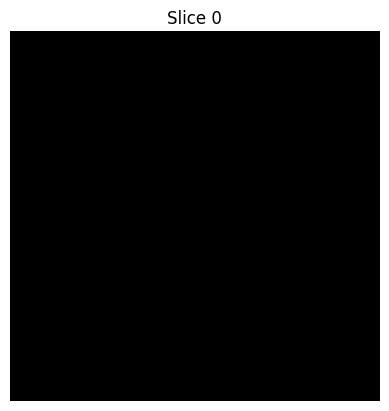

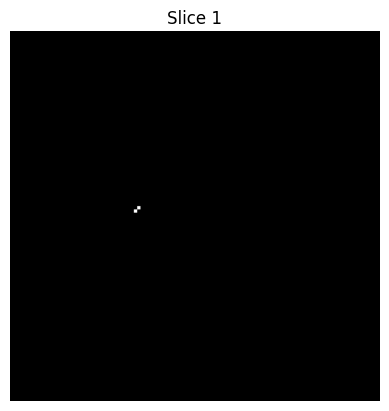

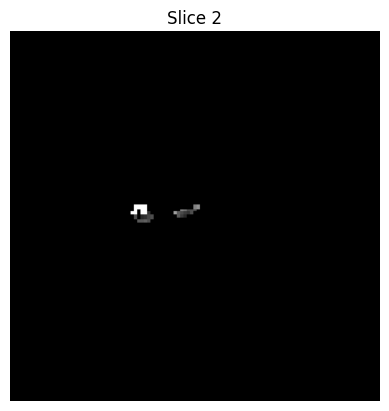

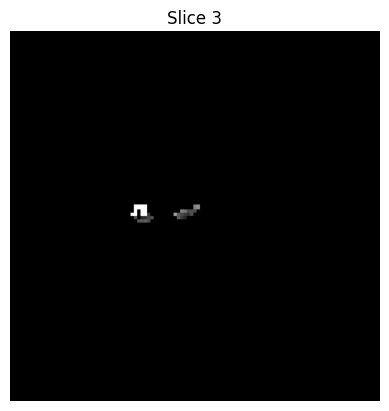

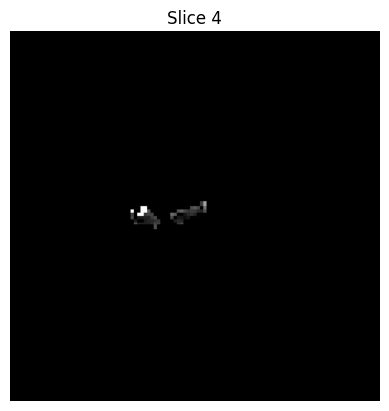

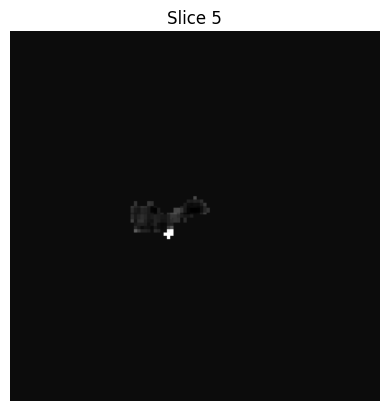

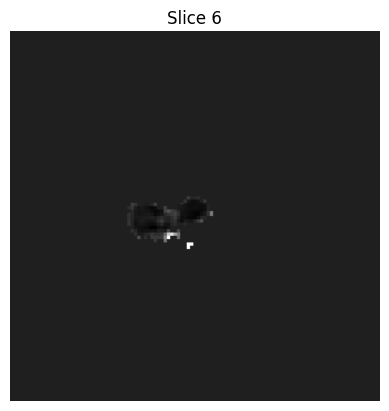

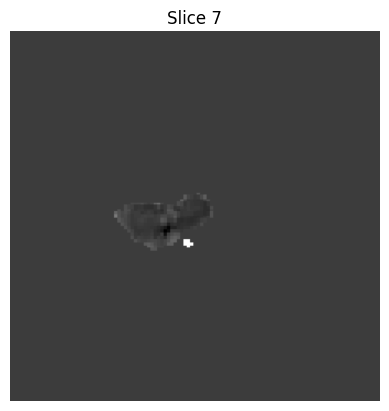

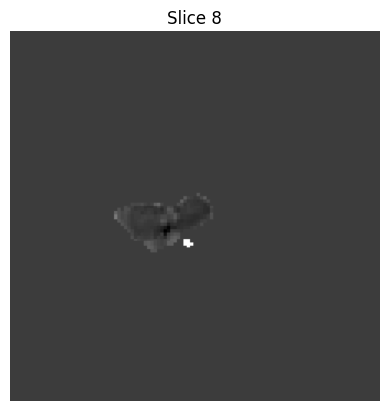

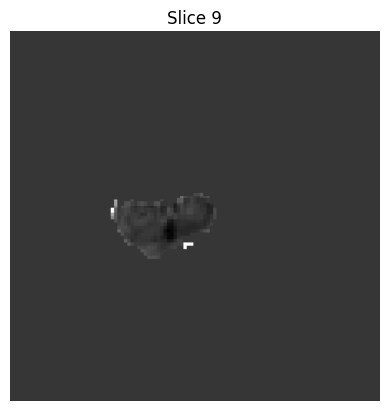

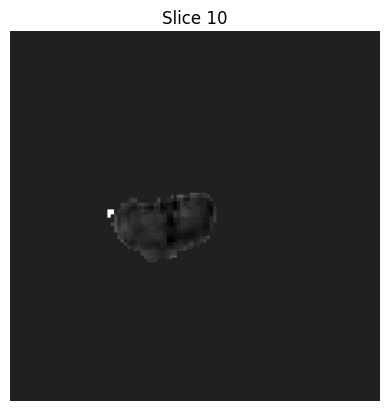

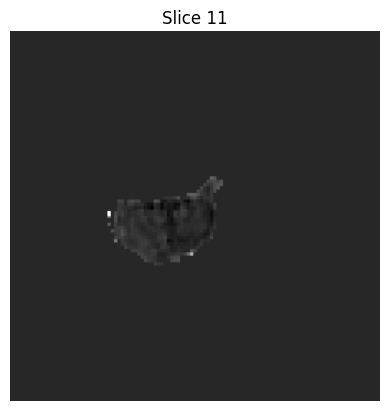

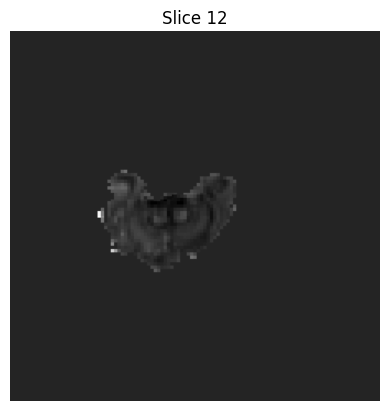

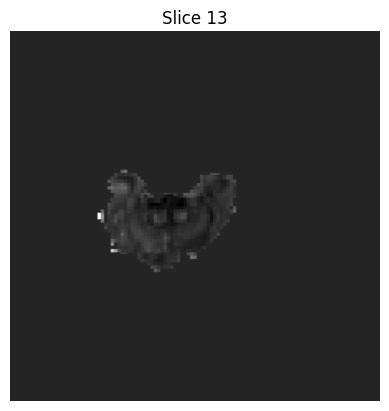

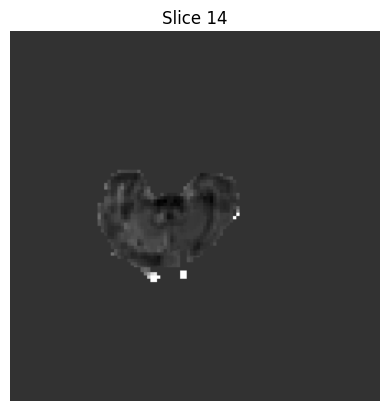

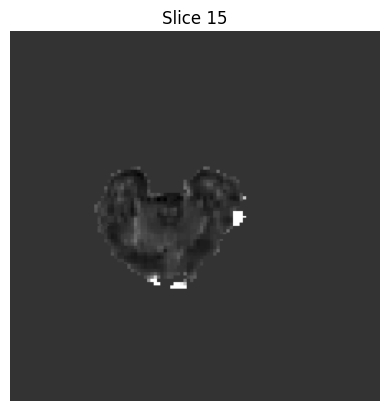

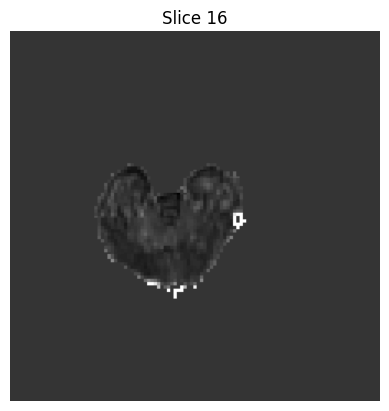

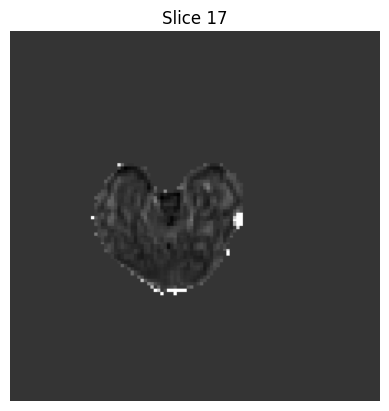

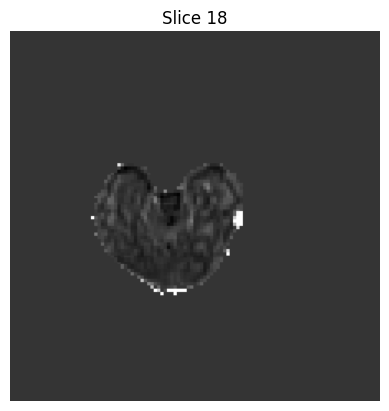

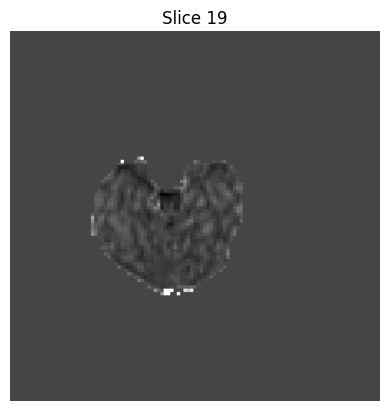

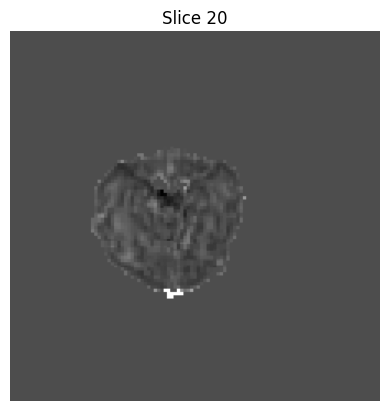

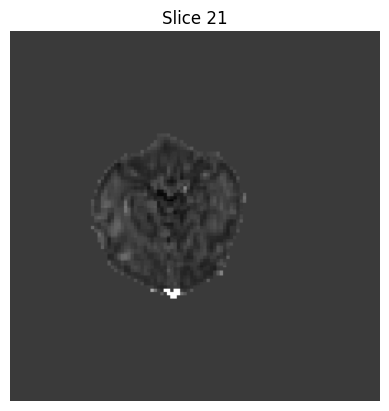

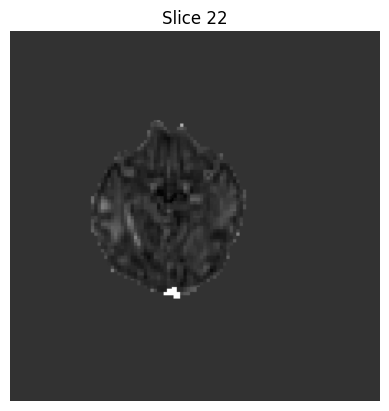

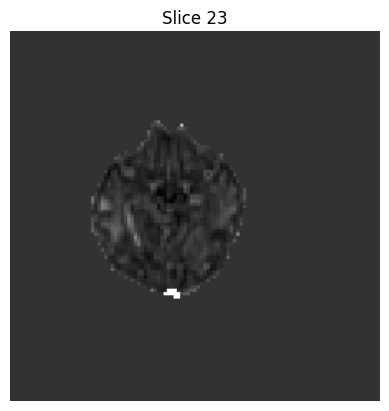

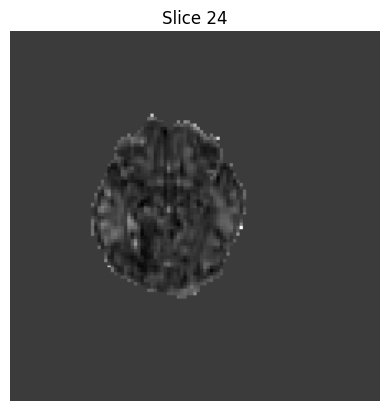

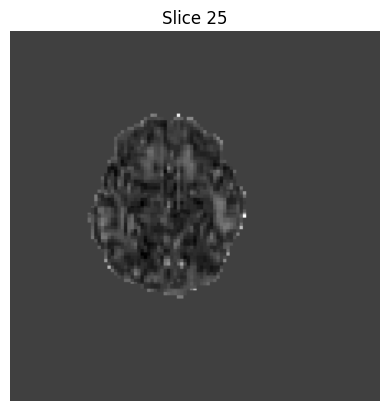

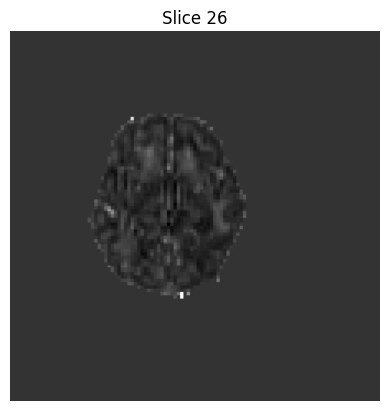

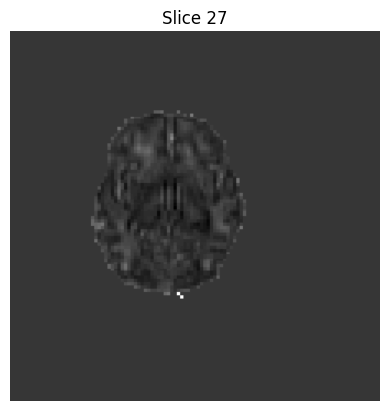

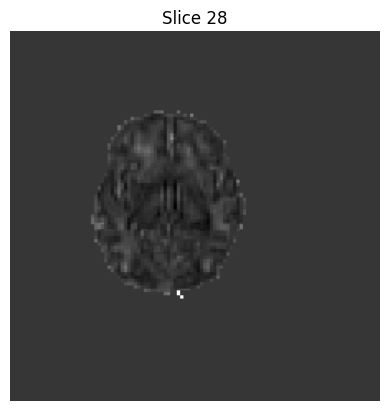

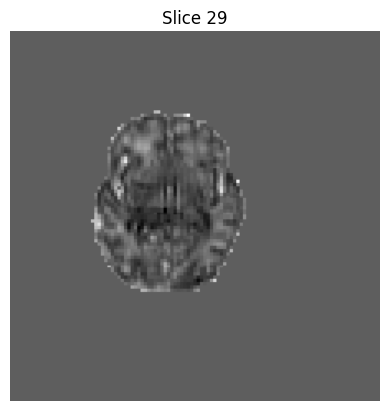

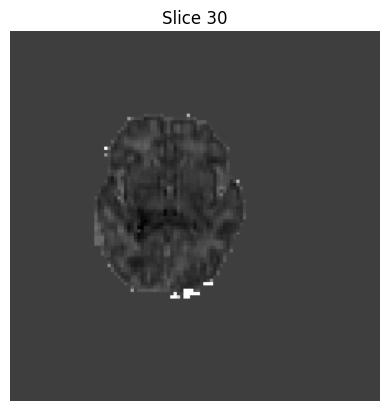

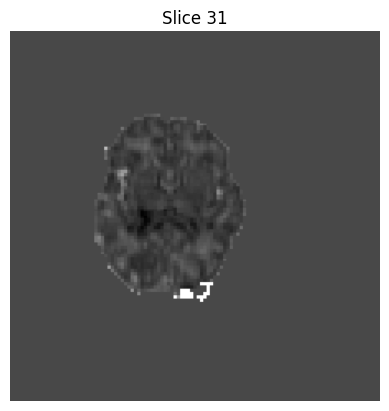

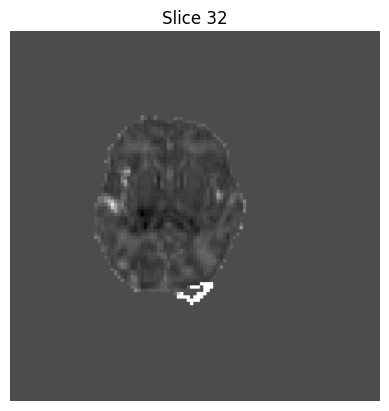

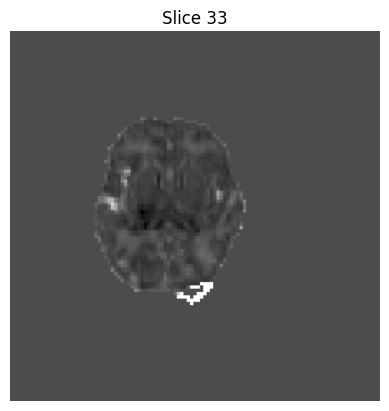

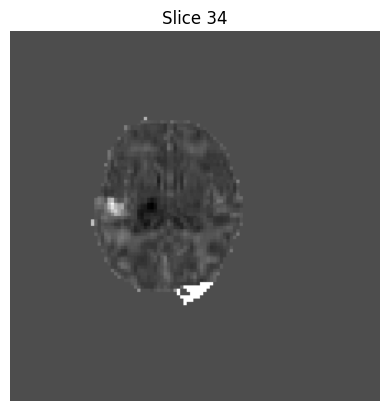

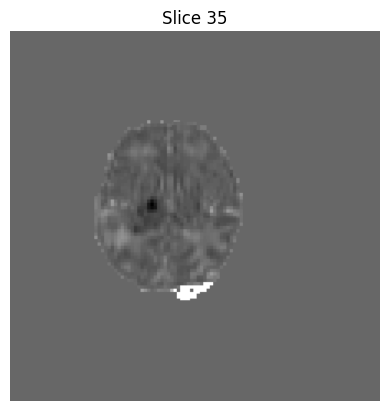

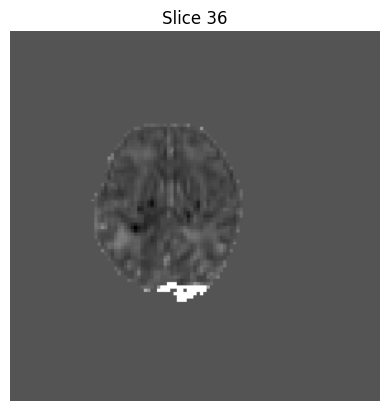

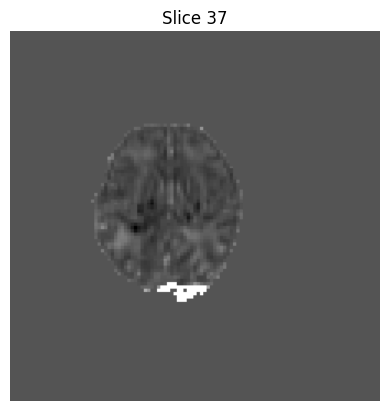

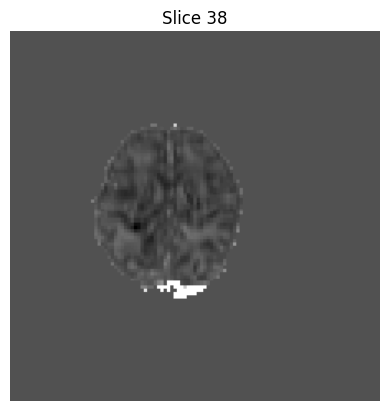

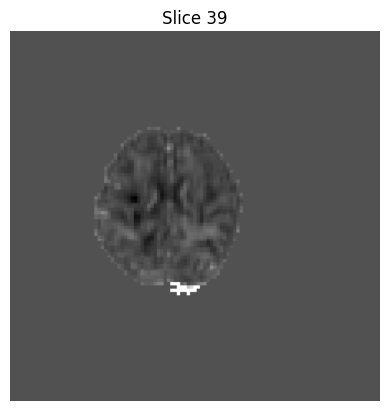

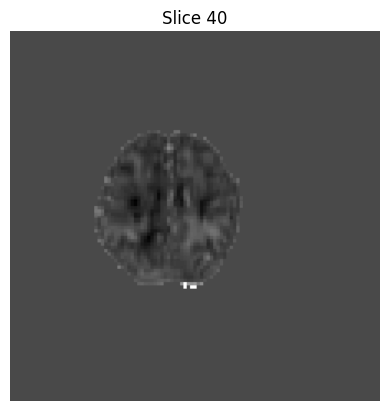

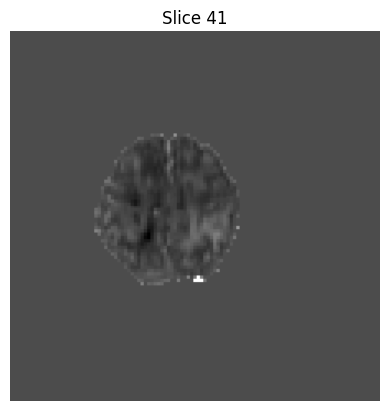

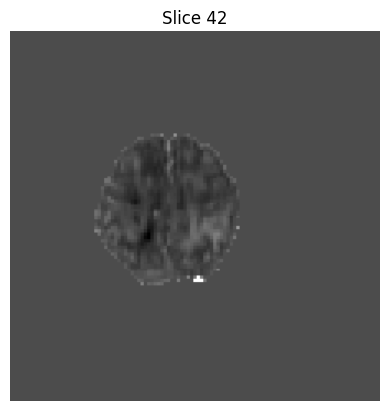

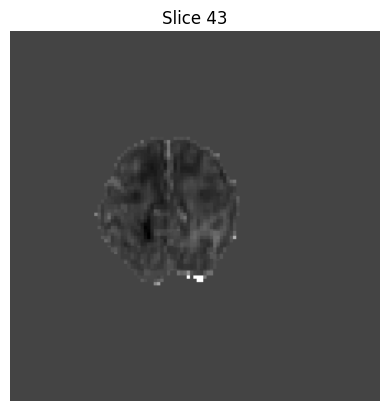

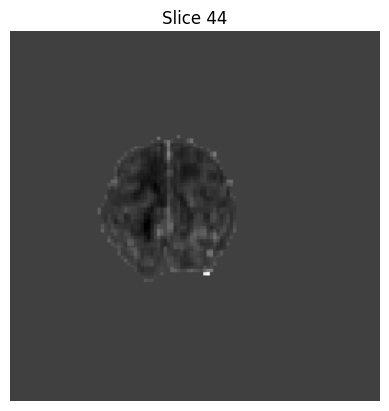

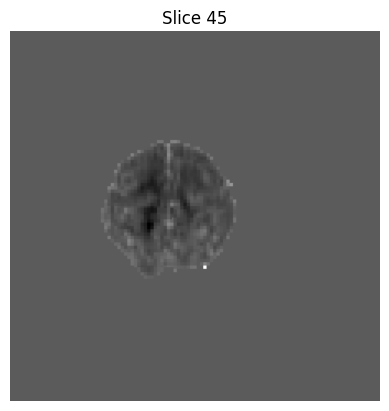

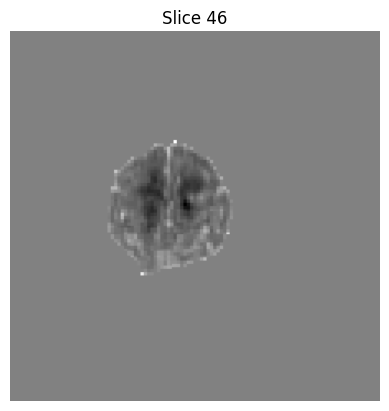

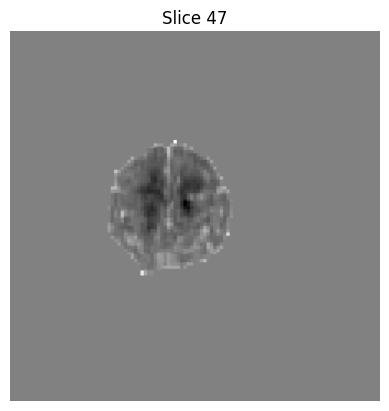

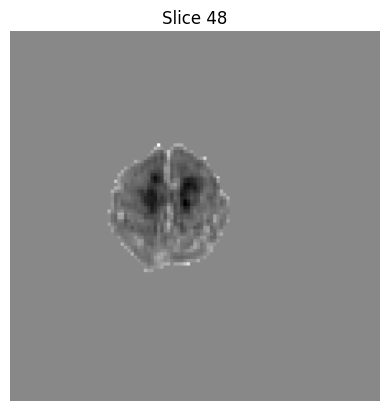

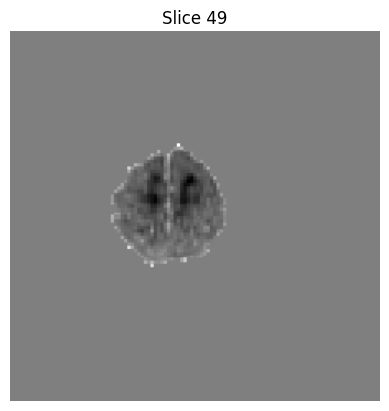

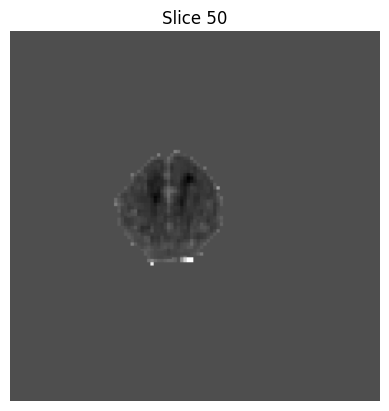

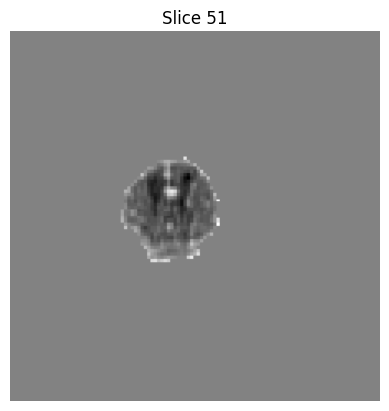

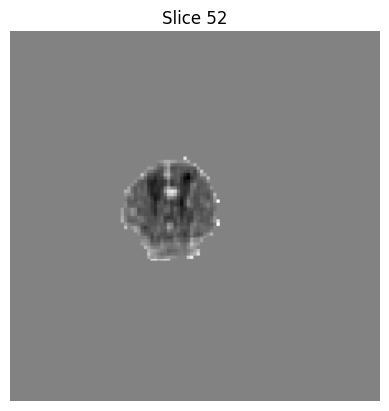

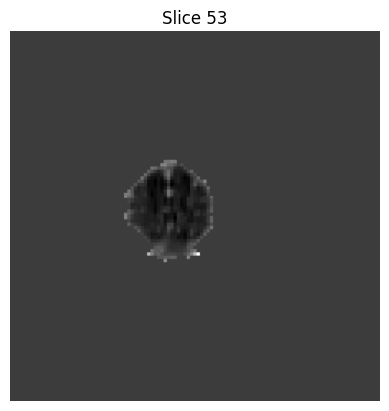

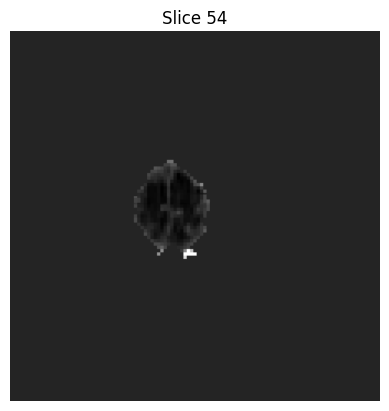

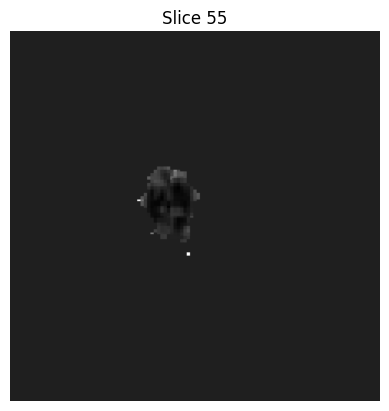

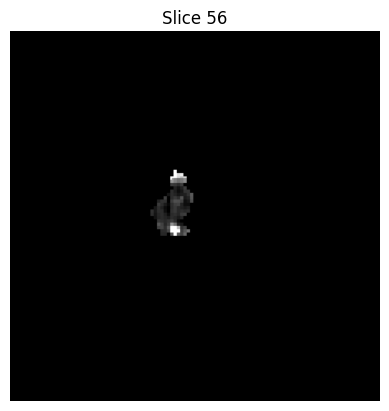

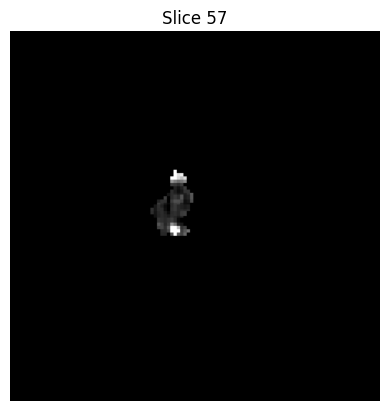

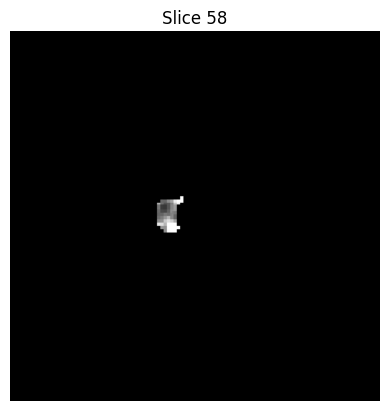

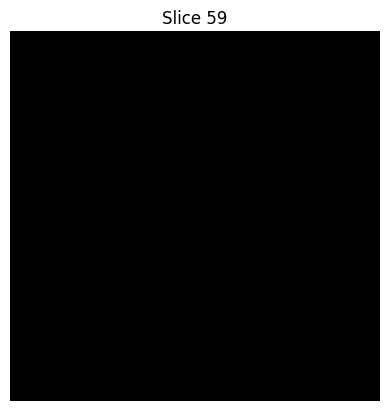

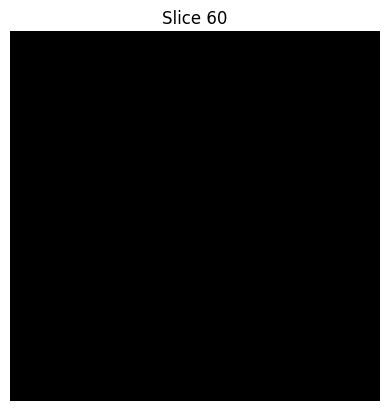

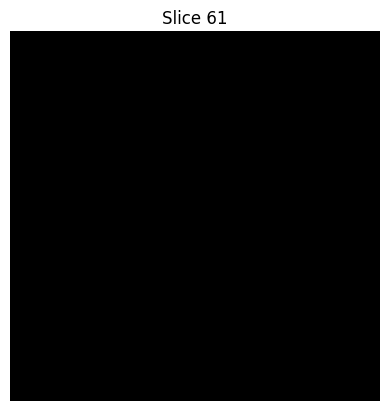

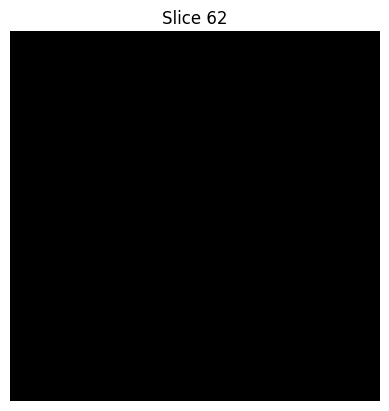

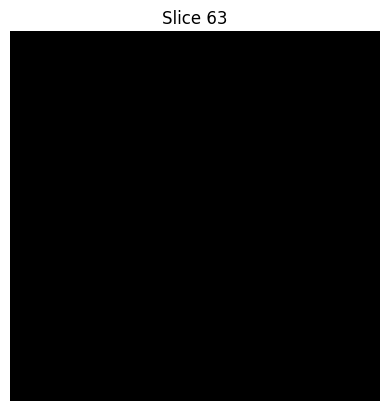

In [ ]:
import matplotlib.pyplot as plt

for i in range(Fusion.shape[3]):  # Iterate through depth (axis 3)
    plt.imshow(Fusion[2, :, :, i], cmap='gray')  # Select the first channel
    plt.axis('off')
    plt.title(f'Slice {i}')
    plt.show()